<center><img src="monai.png"/></center>

<p style="text-align: center">Welcome to the MONAI bootcamp!</p>
<p style="text-align: center">This notebook will introduce you to the MONAI Core design and architecture.  You'll get some hands-on examples with transforms, dataset loaders, caching, and network.</p>

### Using Google Colab

This notebook has the pip command for installing MONAI and will be added to any subsequent notebook.

**Enabling GPU Support**

To use GPU resources through Colab, change the runtime to GPU:

1. From the **"Runtime"** menu select **"Change Runtime Type"**
2. Choose **"GPU"** from the drop-down menu
3. Click **"SAVE"**

This will reset the notebook and probably ask you if you are a robot (these instructions assume you are not)



### Verify GPU Access

Running **!nvidia-smi** in a cell will verify this has worked and show you what kind of hardware you have access to.    

In [1]:
#!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==1.1.0"

### Required Packages for Colab Execution

Execute the following cell to install MONAI the first time a colab notebook is run:

In [2]:
!nvidia-smi

Tue Apr 11 17:11:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   43C    P0   159W / 400W |   2284MiB / 81251MiB |     58%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   

## Getting Started with MONAI

MONAI is a PyTorch-based, open-source framework for deep learning in healthcare imaging, part of the PyTorch Ecosystem.

*Its ambitions are:*

- to develop a community of academic, industrial and clinical researchers collaborating on a common foundation
- to create state-of-the-art, end-to-end training workflows for healthcare imaging
- to provide researchers with the optimized and standardized way to create and evaluate deep learning models

### MONAI End to End workflow

MONAI aims to support deep learning in medical image analysis at multiple levels. This figure shows a typical example of an end-to-end workflow in a medical deep learning context:

<center><img src="end_to_end.png" style="width: 1400px;"/></center>

### What's the Need?

* Biomedical applications have specific requirements
* Image modalities (MR, CT, US, etc.) require specific data processing functionality
* Data formats (DICOM, NIfTI, etc.) are specific to medical applications and require specific support
* Certain network architectures are designed for, or are highly suitable for, biomedical applications
* Data transforms specific to biomedical applications, and to image modalities, are very useful when pre-processing data, augmenting data during training, and for post-processing
* Reproducible science requires reproducible experiments which in turn rely on software accessible to other scientists, even if just as a common baseline
* A community-driven library to provide solutions to these requirements reduces duplication/re-implementation
* Baseline implementations of common networks, and implementations of networks specific to certain papers, provides a basis for comparison between others' networks and results

### How Does MONAI Address This Need?

MONAI provides a framework of deep learning functionality and infrastructure to meet these needs in a flexible, PyTorch-compatible way:
* Direct support for loading and manipulating biomedical file types
* Biomedical-data-specific transforms for regularisation and augmentation of biomedical imaging data for training, validation, and deployment
* Library of general-purpose network, metric, and loss function definitions implementing both established and cutting-edge architectures and features
* Set of ready-made components for training and inference to utilize computing infrastructure efficiently



#### Enhancing Reproducible Data Science

MONAI contributes to reproducible data science by making the training and distribution of experiments easier:
* Common underlying framework aids in comparison and interoperability across user's implementations
* Users can pick and choose components and existing networks, then contribute new code to make their results available to others
* Reference implementations of networks from papers provide baselines for replication studies and comparisons

### MONAI Architecture
By explicit design principle, MONAI provides flexible and light APIs for users with varying expertise:
* All the core components are independent modules, easily integrated into existing PyTorch programs
* Leverage MONAI workflows to quickly set up a robust training or evaluation program for research experiments.
* Rich examples and demos are provided to demonstrate the key features.
* Researchers contribute implementations based on the state-of-the-art for the latest research challenges, including:
  * COVID-19 image analysis
  * Dataset caching mechanisms
  * Model Parallel execution modes
  * and more...


### MONAI Architecture

<br>
<center><img src="arch_modules_v0.4.png" style="width: 1000px;"/></center>

## MONAI Design Philosophy

Key principles:
* MONAI looks like PyTorch, uses/extends PyTorch types and adheres to it's general design philosophy
* MONAI is additive on top of PyTorch, providing extensions or wrappers
* MONAI is opt-in and incremental, no need to rewrite entire models to integrate existing code
* MONAI is collaborative, providing adapters and loosely coupled components to ease integration with third party code
* MONAI is PyTorch ecosystem friendly, and part of the official ecosystem!

## Learning Objectives

To help you understand more about MONAI transforms, dataset caching, and network architectures this guide will help you answer six key questions:

1. **What transforms are available to help create a data pipeline for training?**
2. **What is required to write a custom transform?**
3. **How do I create a basic MONAI dataset with transforms?**
4. **What is a MONAI Dataset and how does dataset caching work?**
5. **What common datasets are provided by MONAI?**
6. **What Network and Network components does MONAI provide and how do you use these components to create a network?**

### Imports

Let's get started by importing our dependecies:
* We're going to load everything that we'll need for the remainder of the notebook here
* You'll see a lot of import statements, but we'll make sure to go over each of them throughout the rest of the notebook.

### Imports

In [3]:
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Any, Mapping, Hashable
import time
import torch

import monai
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection

from monai.data import (Dataset, ArrayDataset, create_test_image_3d, DataLoader, DataLoader, 
CacheDataset, PersistentDataset, SmartCacheDataset)

from monai.transforms import (Transform, MapTransform, Randomizable, EnsureChannelFirst, EnsureChannelFirstd,
Compose, LoadImage, LoadImaged, Lambda, Lambdad, RandSpatialCrop, RandSpatialCropd, RandGaussianNoise,
RandGaussianNoised, Orientation, Rotate, MapTransform)

from monai.apps import DecathlonDataset, TciaDataset
from monai.apps.tcia import TCIA_LABEL_DICT

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Verify your Configuration

Before getting started, it can be helpful to verify your environment setup and make sure all of the dependecies you need are installed. MONAI provides a handy utility to make it easy with `print_config()`

In [4]:
print_config()

MONAI version: 1.0.1
Numpy version: 1.22.2
Pytorch version: 1.13.0a0+d0d6b1f
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.12.1
gdown version: 4.5.3
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.5.0
transformers version: 4.21.3
mlflow version: 1.30.0
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### 1. What transforms are available to help create a data pipeline for training?


#### Medical Image Data I/O, Processing and Augmentation

Medical images require highly specialized methods for I/O, preprocessing, and augmentation. Medical images are often in specialized formats with rich meta-information, and the data volumes are often high-dimensional. These require carefully designed manipulation procedures. The medical imaging focus of MONAI is enabled by powerful and flexible image transformations that facilitate user-friendly, reproducible, optimized medical data pre-processing pipelines.

<img src="medical_transforms.png" />

#### Transforms Support both Dictionary and Array Format Data

The widely used computer vision packages (such as torchvision) focus on spatially 2D array image processing. MONAI provides more domain-specific transformations for both spatially 2D and 3D and retains the flexible transformation “compose” feature.

As medical image preprocessing often requires additional fine-grained system parameters, MONAI provides transforms for input data encapsulated in python dictionaries. Users can specify the keys corresponding to the expected data fields and system parameters to compose complex transformations.

There is a rich set of transforms in six categories: Crop & Pad, Intensity, IO, Post-processing, Spatial, and Utilities. For more details, please visit all the transforms in MONAI.

#### Medical Specific Transforms
MONAI aims at providing a comprehensive medical image specific transformations. These currently include, for example:

* LoadImage: Load medical specific formats file from provided path
* Spacing: Resample input image into the specified pixdim
* Orientation: Change the image’s orientation into the specified axcodes
* RandGaussianNoise: Perturb image intensities by adding statistical noises
* NormalizeIntensity: Intensity Normalization based on mean and standard deviation
* Affine: Transform image based on the affine parameters
* Rand2DElastic: Random elastic deformation and affine in 2D
* Rand3DElastic: Random elastic deformation and affine in 3D

#### Create Toy Data and Temp Directory for Examples

We'll create a temporary directory and populate it with a few example Nifti file-format images containing a random assortment of spheres.  We're also creating a matching segmentation pair that will be used later in the notebook.

In [5]:
fn_keys = ("img", "seg")  # filename keys for image and seg files

root_dir = tempfile.mkdtemp()
filenames = []

for i in range(5):
    im, seg = create_test_image_3d(128, 128, 128, num_objs=16, rad_max=25)

    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"img": im_filename, "seg": seg_filename})

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, im_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

#### Array Transforms

Transforms in MONAI are callable objects accepting inputs from initial data in a dataset or previous transforms. We can create and call these directly without any infrastructure or system setup as components in MONAI are designed to be as decoupled as possible. For example we can load one of our Nifti files directly by creating the transform and calling it.

In [6]:
trans = Compose([LoadImage(image_only=True), EnsureChannelFirst()])
img = trans(filenames[0]["img"])
print(type(img), img.shape, img.get_device())

<class 'monai.data.meta_tensor.MetaTensor'> (1, 128, 128, 128) -1


#### Dictionary Transforms

So far we have seen transforms which are applied to individual Numpy arrays, however for most training schemes a pipeline with multiple values is needed:
* To address this MONAI includes transforms for operating on dictionaries of arrays, one for each equivalent array transform
* These can be applied to named values in an input dictionary while leaving unnamed values untouched
  * for example adding noise to an image while leaving the associated label image untouched.

#### Dictionary Transforms

Earlier in the notebook we imported the dictionary equivalent transforms which have a 'd' appended to their names:
* We'll use those transforms in this section
* The keys argument in LoadNiftid is used to state which keys contain paths to Nifti files
  * All other values in the input dictionary will be retained
  * With this set we can look at the keys returned when calling the transform:

In [7]:
trans = LoadImaged(keys=fn_keys)
data = trans(filenames[0])
print(list(data.keys()))

['img', 'seg', 'img_meta_dict', 'seg_meta_dict']


### What is required to write a custom transform?



#### Custom Array Transform

We can define our own custom transform operation in a number of ways. 

If a simple callable is used as an operator, `Lambda` can be used to wrap it as a transform:
* We define in this example a transform to sum the image in the 1st (width) dimension to produce a 2D image:

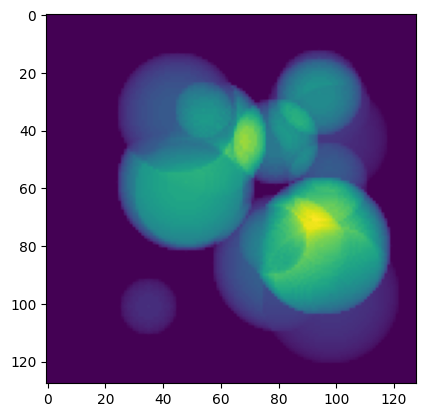

In [8]:
def sum_width(img):
    return img.sum(1)


trans = Compose([LoadImage(image_only=True), EnsureChannelFirst(), Lambda(sum_width)])
img = trans(filenames[0]["img"])
plt.imshow(img[0])

Creating a subclass of Transform is the second method, and this has the advantage of being able to define attributes with the instantiated objects:
* Let's define a class to sum in a chosen dimension, and use it to sum in the 2nd (height) dimension:

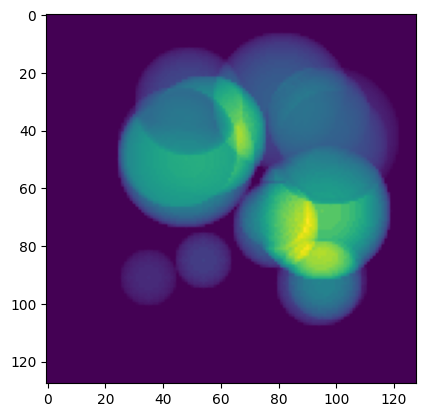

In [9]:
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)


trans = Compose([LoadImage(image_only=True), EnsureChannelFirst(), SumDimension(2)])
img = trans(filenames[0]["img"])
plt.imshow(img[0])

#### Custom Dictionary Transform

`Lambdad` applies the given callable to each array named by `keys` separately:
* We can use this to define transforms operating on different named values in the dictionary at different points in the sequence:

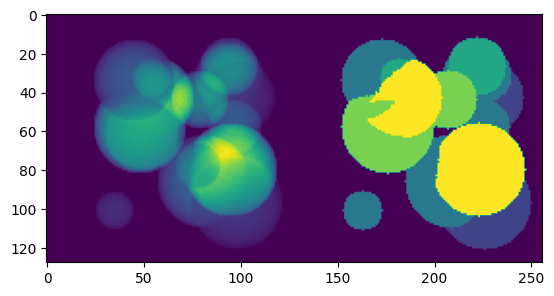

In [10]:
def sum_width(img):
    return img.sum(1)

def max_width(img):
    return img.max(1)

trans = Compose(
    [LoadImaged(fn_keys), EnsureChannelFirstd(fn_keys), Lambdad(("img",), sum_width), Lambdad(("seg",), max_width)]
)

imgd = trans(filenames[0])
img = imgd["img"]
seg = imgd["seg"]

plt.imshow(np.hstack((img[0] * 5 / img.max(), np.squeeze(seg[0]))))

#### Deterministic vs non-deterministic transforms

*Deterministic transforms*: Given same input, produce the same output

*Non-Deterministic transforms*: Given the same input, produce randomized output each time, based on RNG

MONAI's non-deterministic transforms have several useful features:
* By default, each transform has its own RNG
* Datasets can override this (see `ArrayDataset` below)
* You can override it by providing either a 'seed' or a `RandomState` instance


### 3. How do I create a basic MONAI dataset with transforms?

Now that we've taken a look at transform, let's take a look at datasets:
* With a data source and transforms defined we can now create a dataset object
* The base class for MONAI is `Dataset`, created here to load the image Nifti files only
* `Dataset` inherits from the Pytorch class of that name and adds only the ability to apply the given transform to selected items
  * If you're familiar with the class from Pytorch this will work the same way. 

In [11]:
images = [fn["img"] for fn in filenames]

transform = Compose([LoadImage(image_only=True), EnsureChannelFirst()])
ds = Dataset(images, transform)
img_tensor = ds[0]
print(img_tensor.shape, img_tensor.get_device())

(1, 128, 128, 128) -1


#### ArrayDataset

MONAI provides the `ArrayDataset` for supervised training applications:
* Provide one pipeline for images and another for labels
* Typically this is useful when performing augmentations on images that don't make sense for labels
  * Adding noise, normalization, so forth
* Both pipelines use the random state of the dataset to ensure consistency for random operations
  * Caveat: The shared operations must be in the same order
  * Caveat: The shared operations must be before any unshared operations

#### ArrayDataset

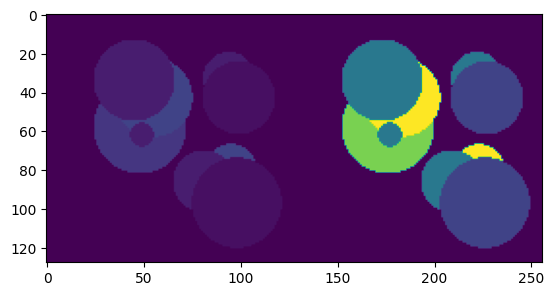

In [12]:
images = [fn["img"] for fn in filenames]
segs = [fn["seg"] for fn in filenames]

img_transform = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        RandSpatialCrop((128, 128, 128), random_size=False),
        RandGaussianNoise(.5, 1, 1),
    ]
)
seg_transform = Compose(
    [LoadImage(image_only=True), EnsureChannelFirst(), RandSpatialCrop((128, 128, 128), random_size=False)]
)

ds = ArrayDataset(images, img_transform, segs, seg_transform)
im, seg = ds[0]
plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

#### Dataset with Dictionary-based Transforms

Alternatively, `Dataset` can be used with dictionary-based transforms to construct a result mapping. For training applications beyond simple input/ground-truth pairs like the above this would be more suitable:

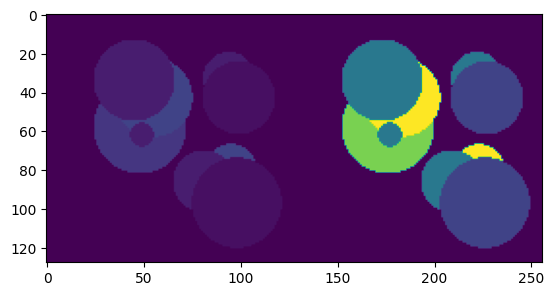

In [13]:
trans = Compose(
    [
        LoadImaged(fn_keys),
        EnsureChannelFirstd(fn_keys),
        RandGaussianNoised(("img",)),
        RandSpatialCropd(fn_keys, (128, 128, 128), random_size=False),
    ]
)

ds = Dataset(filenames, trans)
item = ds[0]
im, seg = item["img"], item["seg"]
plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

#### DataLoader

With the dataset defined, we can now create the dataloader to create data batches:
* Inherits from Pytorch's `DataLoader` class with a few changes to the default constructor arguments
* MONAI functionality is compatible with the PyTorch DataLoader
  * Additional functionality adds key extensions to the standard `DataLoader`


##### Example
* The `DataLoader` example uses five worker processes to load the actual data
* MONAI also provides a number of `Dataset` subclasses to further improve the efficiency of this process

This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


['img', 'seg', 'img_meta_dict', 'seg_meta_dict'] (5, 1, 128, 128, 128)


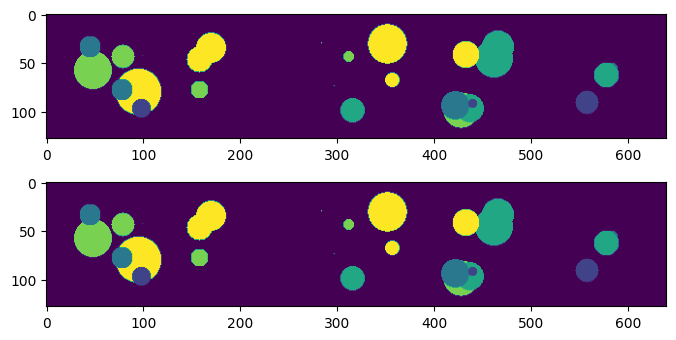

In [14]:
loader = DataLoader(ds, batch_size=5, num_workers=5)
batch = first(loader)
print(list(batch.keys()), batch["img"].shape)

f, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].imshow(np.hstack(batch["img"][:, 0, 64]))
ax[1].imshow(np.hstack(batch["seg"][:, 0, 64]))

### 4. What is a MONAI Dataset and how does dataset caching work?


Users often need to train the model with many (potentially thousands of) epochs over the data to achieve the desired model quality:
* A native PyTorch implementation may repeatedly load data and run the same preprocessing steps for every epoch during training
* Can be time-consuming and unnecessary, especially when the medical image volumes are large
* By utilizing Dataset Caching, you can reduce the amount of time your system takes to load this data and preprocess it
* Reducing your overall training time.

We will demonstrate two of the Dataset subclasses here but there are additional useful specialised `Dataset`s



#### What is a MONAI Dataset?

A MONAI Dataset is a generic dataset with a __len__ property, __getitem__ property, and an optional callable data transform when fetching a data sample.

We'll start by initializing some generic data, calling the Dataset class with the generic data, and specifying None for our transforms.

In [15]:
items = [{"data": 4}, 
         {"data": 9}, 
         {"data": 3}, 
         {"data": 7}, 
         {"data": 1},
         {"data": 2},
         {"data": 5}]
dataset = monai.data.Dataset(items, transform=None)

print(f"Length of dataset is {len(dataset)}")
for item in dataset:
    print(item)

Length of dataset is 7
{'data': 4}
{'data': 9}
{'data': 3}
{'data': 7}
{'data': 1}
{'data': 2}
{'data': 5}


#### Dataset compatibility with PyTorch DataLoader

MONAI datasets can be used with vanilla PyTorch DataLoader:
* As mentioned, MONAI's `DataLoader` has additional useful functionality

In [16]:
for item in torch.utils.data.DataLoader(dataset, batch_size=2):
    print(item)

{'data': tensor([4, 9])}
{'data': tensor([3, 7])}
{'data': tensor([1, 2])}
{'data': tensor([5])}


#### What is Dataset Caching and how do I use it?

MONAI provides multi-thread versions of `CacheDataset` and `LMDBDataset` to accelerate transformation pipelines during training:
 * put deterministic transforms first, and random transforms after
 * the output of the deterministic transforms is always the same, so only compute once!
 * random transforms produce different outputs each time they are used so must be computed every time
   * can provide up to 10x training speedup in the Datasets experiment.
 
<img src="cache_dataset.png" style="width: 700px;"/>
 


To demonstrate the benefit dataset caching, we're going to construct a dataset with a slow transform:
 * To do that, we're going to call the sleep function during each of the `__call__` functions.

In [17]:
class SlowSquare(MapTransform):
    def __init__(self, keys):
        MapTransform.__init__(self, keys)
        print(f"keys to square it: {self.keys}")

    def __call__(self, x):
        time.sleep(1.0)
        output = {key: x[key] ** 2 for key in self.keys}
        return output

square_dataset = Dataset(items, transform=SlowSquare(keys="data"))

keys to square it: ('data',)


As expected, it's going to take about 7 seconds to go through all the items.

In [18]:
%time for item in square_dataset: print(item)

{'data': 16}
{'data': 81}
{'data': 9}
{'data': 49}
{'data': 1}
{'data': 4}
{'data': 25}
CPU times: user 4.67 ms, sys: 151 µs, total: 4.82 ms
Wall time: 7.01 s


Every time we run this loop it takes roughly 7 seconds to go through all of the items:
 * 12 extra minutes of load time for 100 epochs
 * We can improve this time by utilizing caching.

#### Cache Dataset

When using [CacheDataset](https://docs.monai.io/en/latest/data.html?highlight=dataset#cachedataset) the caching is done when the object is initialized for the first time, so the initialization is slower than a regular dataset:
* By caching the results of non-random preprocessing transforms, it accelerates the training data pipeline
* If the requested data is not in the cache, all transforms will run normally.

In [19]:
square_cached = CacheDataset(items, transform=SlowSquare(keys='data'))

keys to square it: ('data',)


Loading dataset: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


However, repeatedly fetching the items from an initialized CacheDataset is fast.

In [20]:
%timeit list(square_cached)

8.51 µs ± 12.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Persistent Caching

[PersistentDataset](https://docs.monai.io/en/latest/data.html?highlight=dataset#persistentdataset) allows for persistent storage of pre-computed values to efficiently manage larger than memory dictionary format data:
* Again, the non-random transform components are computed when first used
* Stored in the cache_dir for rapid retrieval on subsequent uses

In [21]:
square_persist = monai.data.PersistentDataset(items, transform=SlowSquare(keys='data'), cache_dir="my_cache")

%time for item in square_persist: print(item)

keys to square it: ('data',)
{'data': 16}
{'data': 81}
{'data': 9}
{'data': 49}
{'data': 1}
{'data': 4}
{'data': 25}
CPU times: user 1.84 ms, sys: 0 ns, total: 1.84 ms
Wall time: 20.1 ms


During the initialization of the PersistentDataset we passed in the parameter "my_cache" for the location to store the intermediate data. We'll look at that directory below.

In [22]:
!ls my_cache

57d3e1f66415b9a6a36a90dd89c708c3.pt  acdbabea1a1facbf07dbe5010a951af9.pt
5ec8e24ba3963d83f2f6c81744796545.pt  ca0b3885ae71075716d5bd863961a8bc.pt
6c81bd5aa312ecd4ba9a5e0340e06a55.pt  f263a1a8f1344ac65b574f0bf30813af.pt
71177f0b196d6c5f84f26579bf19caae.pt


When calling out to the dataset on the following epochs, it will not call the slow transform but used the cached data.

In [23]:
%timeit list(square_persist)

2.7 ms ± 45.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Fresh dataset instances can make use of the caching data:

In [24]:
square_persist_1 = monai.data.PersistentDataset(items, transform=SlowSquare(keys='data'), cache_dir="my_cache")
%timeit list(square_persist_1)

keys to square it: ('data',)
2.66 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Caching in action

- There's also a [SmartCacheDataset](https://docs.monai.io/en/latest/data.html#monai.data.SmartCacheDataset) to hide the transforms latency with less memory consumption.
- The dataset tutorial notebook has a working example and a comparison of different caching mechanism in MONAI: https://github.com/Project-MONAI/tutorials/blob/master/acceleration/dataset_type_performance.ipynb

<center><img src="datasets_speed.png" style="width: 700px;"/></center>

### 5. What common datasets are provided by MONAI?

To quickly get started with popular training data in the medical domain, MONAI provides several data-specific Datasets:
* MedNISTDataset, DecathlonDataset, etc.
* Provides easy downloading from our AWS storage, extraction of data files and supports generation of training/evaluation items with transforms

##### Decathlon Dataset 

The [DecathlonDataset](https://docs.monai.io/en/latest/data.html?highlight=dataset#decathlon-datalist) function leverages the features described throughout this notebook.  These datasets are an extension of CacheDataset covered above.

In [25]:
dataset = monai.apps.DecathlonDataset(root_dir="./", task="Task09_Spleen", section="training", download=True)

Task09_Spleen.tar: 1.50GB [01:09, 23.2MB/s]                               


2023-04-11 17:13:35,090 - INFO - Downloaded: Task09_Spleen.tar
2023-04-11 17:13:37,677 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-04-11 17:13:37,679 - INFO - Writing into directory: ..


Loading dataset: 100%|██████████| 33/33 [02:40<00:00,  4.87s/it]


In [26]:
print(dataset.get_properties("numTraining"))
print(dataset.get_properties("description"))
print(dataset[0]['image'].shape)
print(dataset[0]['label'].shape)

{'numTraining': 41}
{'description': 'Spleen Segmentation'}
(512, 512, 55)
(512, 512, 55)


##### TCIA Dataset

The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/) is a service which de-identifies and hosts a large publicly available archive of medical images of cancer:
* TCIA is funded by the [Cancer Imaging Program (CIP)](https://imaging.cancer.gov/), a part of the United States [National Cancer Institute (NCI)](https://www.cancer.gov/), and is managed by the [Frederick National Laboratory for Cancer Research (FNLCR)](https://frederick.cancer.gov/).
* The `TciaDataset` function will automatically download and extract the TCIA datasets with accompanying DICOM segmentations, and act as PyTorch datasets to generate training/validation/test data.

##### TCIA Dataset


In [27]:
# Let's take the "QIN-PROSTATE-Repeatability" collection for example
collection, seg_type = "QIN-PROSTATE-Repeatability", "SEG"

ds = TciaDataset(
    root_dir="./",
    collection=collection,
    section="training",
    download=True,
    download_len=1,
    seg_type=seg_type,
    progress=True,
    cache_rate=0.0,
    val_frac=0.2,
)
print(ds.datalist[0])
print(len(ds.datalist))

2023-04-11 17:16:23,829 - INFO - Expected md5 is None, skip md5 check for file QIN-PROSTATE-Repeatability/1.2.276.0.7230010.3.1.3.1426846371.19508.1513205205.886.zip.
2023-04-11 17:16:23,830 - INFO - File exists: QIN-PROSTATE-Repeatability/1.2.276.0.7230010.3.1.3.1426846371.19508.1513205205.886.zip, skipped downloading.
2023-04-11 17:16:23,835 - INFO - Writing into directory: ./QIN-PROSTATE-Repeatability/raw/1.2.276.0.7230010.3.1.3.1426846371.19508.1513205205.886.
2023-04-11 17:16:23,985 - INFO - Expected md5 is None, skip md5 check for file QIN-PROSTATE-Repeatability/1.3.6.1.4.1.14519.5.2.1.3671.4754.250530982889039458942609884846.zip.
2023-04-11 17:16:23,986 - INFO - File exists: QIN-PROSTATE-Repeatability/1.3.6.1.4.1.14519.5.2.1.3671.4754.250530982889039458942609884846.zip, skipped downloading.
2023-04-11 17:16:23,992 - INFO - Writing into directory: ./QIN-PROSTATE-Repeatability/PCAMPMRI-00015/1901/image.
{'image': 'QIN-PROSTATE-Repeatability/PCAMPMRI-00015/1901/image', 'seg': 'QIN-

### What Network and Network components does MONAI provide and how do you use these components to create a network?

MONAI provides definitions for networks and their components that inherit directly from Pytorch Module, Sequential, etc. These general purpose networks include parameterized topologies that can easily be expanded are independent from rest of MONAI so networks can be used with existing training code.

MONAI includes the following submodules:
* layers: defines low level layers, factories for selecting Pytorch and custom layers based on dimension and other arguments
* blocks: mid-level building blocks defining specific reusable concepts networks are constructed from
* nets: full network definitions for common architectures, eg. UNet, VNet, Densenet,


Blocks and networks use LayerFactory objects as generic factory for custom and PyTorch layers.

MONAI provides blocks for defining:
- Convolution with activation and regularization
- Residual units
- Squeeze/excitation
- Downsampling/upsampling
- Subpixel convolutions

#### How do you use MONAI Layers?

Network functionality represents a significant design opportunity for MONAI:
* Pytorch is very much unopinionated in how networks are defined
* It provides Module as a base class to create a network and a few methods that must be implemented
* Still, there is no prescribed pattern nor much helper functionality for initializing networks.

The lack of helper functionality leaves a lot of room for defining some beneficial 'best practice' patterns for constructing new networks in MONAI:
* Although trivial, inflexible network implementations are easy enough
* We give users a toolset that makes it much easier to build well-engineered, flexible networks and demonstrate their value by committing to use them in the networks that we build

In [28]:
from monai.networks.layers import Conv, Act, split_args, Pool

##### Convolutions

The [Conv](https://docs.monai.io/en/latest/networks.html#convolution) class has two options for the first argument. The second argument must be the number of spatial dimensions, `Conv[name, dimension]`, for example:

In [29]:
print(Conv[Conv.CONV, 1])
print(Conv[Conv.CONV, 2])
print(Conv[Conv.CONV, 3])
print(Conv[Conv.CONVTRANS, 1])
print(Conv[Conv.CONVTRANS, 2])
print(Conv[Conv.CONVTRANS, 3])

<class 'torch.nn.modules.conv.Conv1d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv3d'>
<class 'torch.nn.modules.conv.ConvTranspose1d'>
<class 'torch.nn.modules.conv.ConvTranspose2d'>
<class 'torch.nn.modules.conv.ConvTranspose3d'>


The configured classes are the "vanilla" PyTorch layers. We could create instances of them by specifying the layer arguments:

In [30]:
print(Conv[Conv.CONV, 2](in_channels=1, out_channels=4, kernel_size=3))
print(Conv[Conv.CONV, 3](in_channels=1, out_channels=4, kernel_size=3))

Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1))


##### Activiation

The [Act](https://docs.monai.io/en/latest/networks.html#module-monai.networks.layers.Act) classes don't require the spatial dimension information, but supports additional arguments.

In [31]:
print(Act[Act.PRELU])
Act[Act.PRELU](num_parameters=1, init=0.1)

<class 'torch.nn.modules.activation.PReLU'>


PReLU(num_parameters=1)

These could be fully specified with a tuple of `(type_name, arg_dict)`, such as `("prelu", {"num_parameters": 1, "init": 0.1})`:

In [32]:
act_name, act_args = split_args(("prelu", {"num_parameters": 1, "init": 0.1}))
Act[act_name](**act_args)

PReLU(num_parameters=1)

#### How do you use these components to create a network?

##### Flexible Definition Networks

These APIs allow for flexible definitions of networks.  Below we'll create a class called `MyNetwork` that utilizes `Conv`, `Act`, and `Pool`.  Each Network requires an `__init__` and a `forward` function.

In [33]:
class MyNetwork(torch.nn.Module):
    def __init__(self, dims=3, in_channels=1, out_channels=8, kernel_size=3, pool_kernel=2, act="relu"):
        super(MyNetwork, self).__init__()
        # convolution
        self.conv = Conv[Conv.CONV, dims](in_channels, out_channels, kernel_size=kernel_size)
        # activation
        act_type, act_args = split_args(act)
        self.act = Act[act_type](**act_args)
        # pooling
        self.pool = Pool[Pool.MAX, dims](pool_kernel)

    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = self.act(x)
        x = self.pool(x)
        return x

##### Example Instantiations

This network definition can be instantiated to support either 2D or 3D inputs, with flexible kernel sizes.  It becomes handy when adapting the same architecture design for different tasks, switching among 2D, 2.5D, 3D easily.

In [34]:
# default network instance
default_net = MyNetwork()
print(default_net)
print(default_net(torch.ones(3, 1, 20, 20, 30)).shape)

# 2D network instance
elu_net = MyNetwork(dims=2, in_channels=3, act=("elu", {"inplace": True}))
print(elu_net)
print(elu_net(torch.ones(3, 3, 24, 24)).shape)

# 3D network instance with anisotropic kernels
sigmoid_net = MyNetwork(3, in_channels=4, kernel_size=(3, 3, 1), act="sigmoid")
print(sigmoid_net)
print(sigmoid_net(torch.ones(3, 4, 30, 30, 5)).shape)

MyNetwork(
  (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (act): ReLU()
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([3, 8, 9, 9, 14])
MyNetwork(
  (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (act): ELU(alpha=1.0, inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([3, 8, 11, 11])
MyNetwork(
  (conv): Conv3d(4, 8, kernel_size=(3, 3, 1), stride=(1, 1, 1))
  (act): Sigmoid()
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([3, 8, 14, 14, 2])


### MONAI Networks

MONAI provides over 20 Networks including:
- UNet
- VNet
- AHNet
- VGG-like regressor, classifier, discriminator, critic
- HighResNet
- SENet
- UNETR

### Example UNets

We'll define a 2D UNet network with 2 hidden layers having outputs with 8 channels, and a bottom (bottleneck) layer producing outputs with 32 channels.  The stride values state the stride for the initial convolution, ie. downsampling in down path and upsampling in up path and it'll transpose the convolutions used to implement upsampling.


In [35]:
net = monai.networks.nets.UNet(
    spatial_dims=2,  # 2 or 3 for a 2D or 3D network
    in_channels=1,  # number of input channels
    out_channels=1,  # number of output channels
    channels=[8, 16, 32],  # channel counts for layers
    strides=[2, 2]  # strides for mid layers
)

In [36]:
!which python

/opt/conda/bin/python


## Summary

We've covered MONAI Transforms, Datasets, Caching and Networks.  Some key highlights are:

- There is a long list of medical specific transforms available in MONAI
- There are array and dictionary versions of transforms.
- You can create a simple callable lambda function or create a class based on transform to create your own custom tranform
- You can create a MONAI dataset and directly pass a compose tranform chain to it
- A MONAI Dataset is a generic dataset with a len property, getitem property, and an optional callable data transform when fetching a data sample.


## Summary
- You can use dataset caching to store dataset transforms to speed up training.  Some included Caching options are CachingDataset, PersistentCaching, and SmartCaching
- MONAI provides access to some commonly used medical imaging datasets including the DecathlonDataset
- Understanding the basic MONAI Layers, Blocks, and Networks
- Use MONAI layers to implement a flexible network and instnaite a two UNet examples with different parameters